In [23]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
from muon import atac as ac
import pandas as pd

import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

['default', 'despine']


In [2]:
color_dict = { 'Prlf. Ductal': '#f7b6d2', 'Ductal': '#d62728', 'Imm. Acinar': '#ffeb3b', 'Mat. Acinar': '#98df8a',
    'Alpha': '#1f77b4', 'Beta': '#ff7f0e', 'Delta': '#279e68', 'Eps. progenitors': '#aa40fc', 'Epsilon': '#8c564b',
       'Fev+': '#e377c2', 'Fev+ Alpha': '#b5bd61', 'Fev+ Beta': '#aec7e8', 'Fev+ Delta': '#aec7e8', 'Fev+ Delta,0': '#ffbb78', 'Fev+ Delta,1':'#98df8a',
        'Fev+ Delta,2': '#17becf', 'Ngn3 high cycling': '#aec7e8',
        'Ngn3 high,0': '#ff9896', 'Ngn3 high': '#ff9896', 'Ngn3 high,1':'#f0b98d', 'Ngn3 low': '#c5b0d5'
}

In [3]:
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.5.1 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [4]:
output_dir = "."

In [5]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_processed.h5ad")

In [8]:
new_annotation = pd.read_csv("../EDA/endocrine_refinement.csv")

In [9]:
adata.obs["Fev_delta_refinement"] = new_annotation["Fev_delta_refinement"].values
adata.obs["Ngn3_high_refinement"] = new_annotation["Ngn3_high_refinement"].values
adata.obs["refinement"] = new_annotation["refinement"].values

In [10]:
endocrine_celltypes = [
    "Ngn3 low",
    "Ngn3 high",
    "Ngn3 high cycling",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Eps. progenitors",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon"
]

In [11]:
adata = adata[adata.obs["celltype"].isin(endocrine_celltypes)].copy()

In [12]:
adata.obs["refinement"] = adata.obs["refinement"].astype("category")
adata.uns["refinement_colors"] = [color_dict[ct] for ct in adata.obs["refinement"].cat.categories]

In [13]:
adata.uns["celltype_colors"] = [color_dict[ct] for ct in adata.obs["celltype"].cat.categories]

In [14]:
adata_gex = adata[:,adata.var["modality"]=="GEX"].copy()

In [15]:
adata_atac = adata[:,adata.var["modality"]=="ATAC"].copy()

In [16]:
sc.pp.normalize_total(adata_gex)
sc.pp.pca(adata_gex)

In [17]:
sc.tl.dendrogram(adata_gex, groupby="refinement")

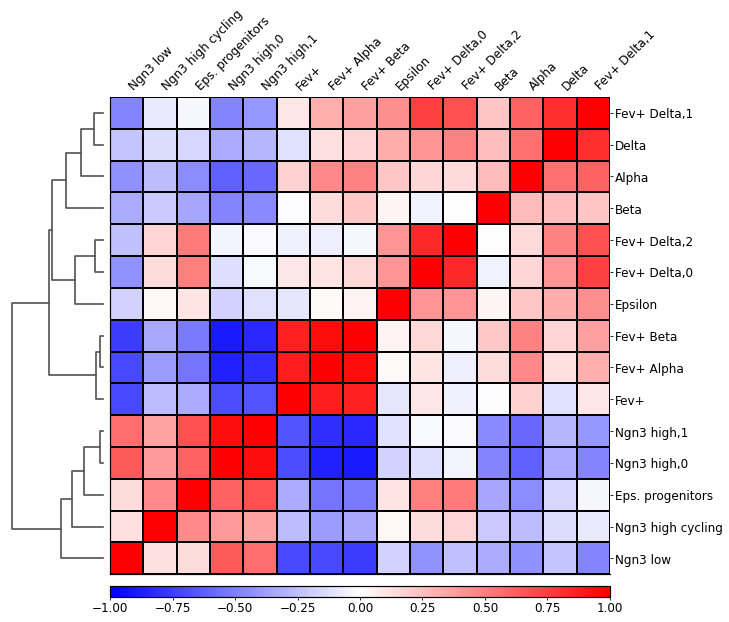

In [18]:
sc.pl.correlation_matrix(adata_gex, "refinement")

In [19]:
ac.pp.tfidf(adata_atac, scale_factor=1e4)

In [20]:
sc.pp.normalize_per_cell(adata_atac, counts_per_cell_after=1e4)
sc.pp.log1p(adata_atac)

In [21]:
ac.tl.lsi(adata_atac, n_comps=30)

In [24]:
depth_corr = [np.corrcoef(adata_atac.obsm["X_lsi"][:,i], adata_atac.obs["nCount_ATAC"])[1,0] for i in range(adata_atac.obsm["X_lsi"].shape[1])]

In [25]:
comps_to_remove = np.where(np.abs(depth_corr) > 0.4)[0]
comps_to_remove

array([0, 3])

In [26]:
subset = list(set(range(adata_atac.obsm["X_lsi"].shape[1])) - set(comps_to_remove))

In [27]:
adata_atac.obsm['X_lsi'] = adata_atac.obsm['X_lsi'][:,subset]

In [28]:
sc.tl.dendrogram(adata_atac, groupby="refinement", use_rep="X_lsi")

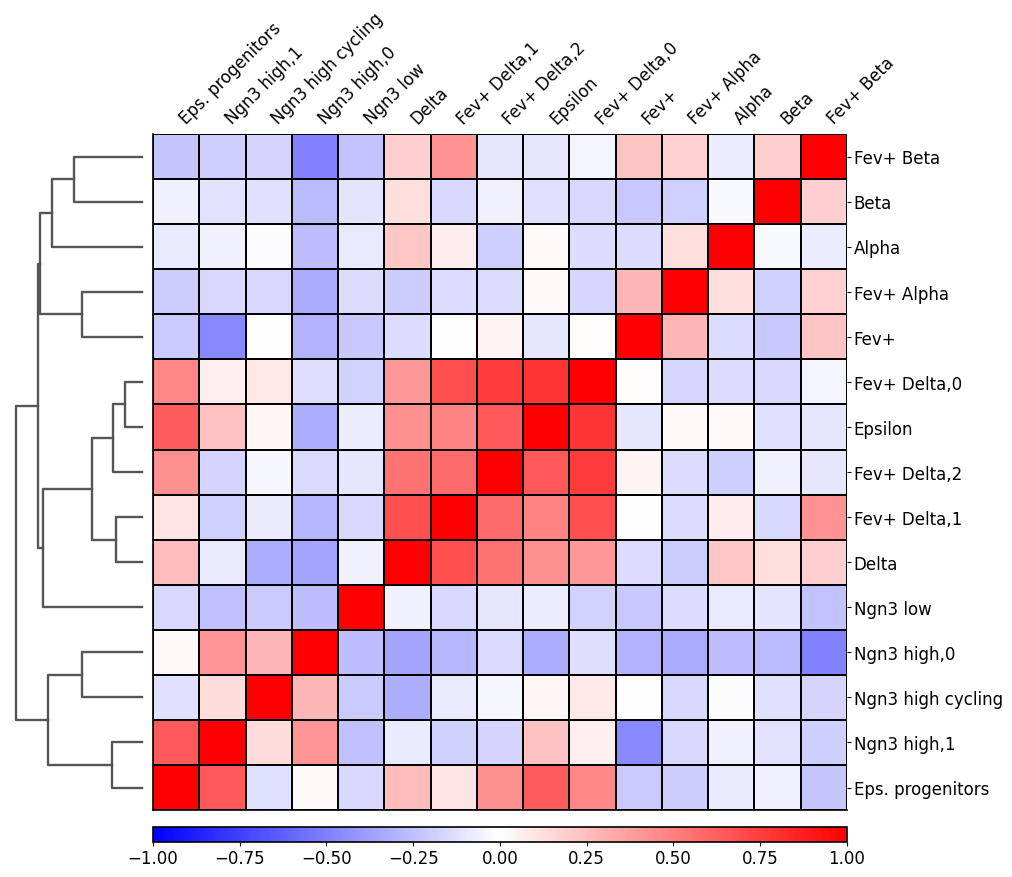

In [29]:
sc.pl.correlation_matrix(adata_atac, "refinement")

In [33]:
adata_gex.obsm["combined"] = np.hstack((adata_gex.obsm["X_pca"], adata_atac.obsm["X_lsi"]))

In [36]:
sc.tl.dendrogram(adata_gex, groupby="refinement", use_rep="combined")

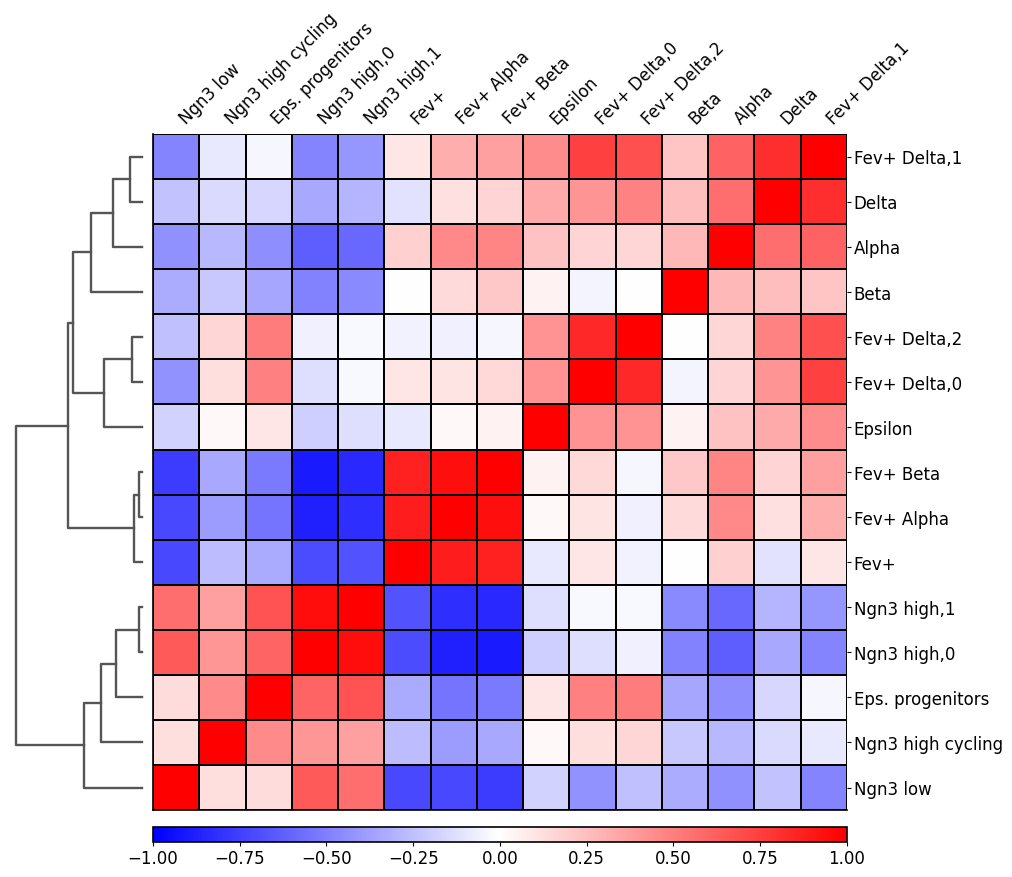

In [37]:
sc.pl.correlation_matrix(adata_gex, "refinement")